# Modelo *RMFT* ($\sigma$-$\omega$) para la EoS de Estrellas de Neutrones

In [95]:
# Importamos las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.size'] = 15
from scipy.integrate import odeint, quad
from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve

## Ecuacion de Estado del Modelo

En términos de los campos medios $\sigma$ y $\omega_0$, podemos escribir la densidad de número, la densidad de energía y la presión de la estrella de neutrones como (unidades geometrizadas):

$$ n = \frac{2p_F^3}{3\pi^2\hbar^3} \iff p_F(n) = \left(\frac{3\pi^2\hbar^3 n}{2}\right)^{1/3}$$ 
$$ \rho = \frac{1}{2}\frac{m_\sigma^2}{\hbar^2} \sigma^2 + \frac{1}{2}\frac{m_\omega^2}{\hbar^2} \omega_0^2 + \frac{2}{\pi^2 \hbar^3} \int_0^{p_F} p^2 \sqrt{p^2 + (m - g_\sigma \sigma)^2} dp$$
$$ P = -\frac{1}{2}\frac{m_\sigma^2}{\hbar^2} \sigma^2 + \frac{1}{2}\frac{m_\omega^2}{\hbar^2} \omega_0^2 - \frac{2}{3\pi^2\hbar^3} \int_0^{p_F} \frac{p^4}{\sqrt{p^2 + (m - g_\sigma \sigma)^2}} dk$$

además, el sistema cumple las ecuaciones de campo:

$$ g_\sigma \sigma = \frac{g_\sigma^2}{m_\sigma^2} \frac{2}{\pi^2 \hbar} \int_0^{p_F} \frac{m - g_\sigma \sigma}{\sqrt{p^2 + (m - g_\sigma \sigma)^2}} p^2 dp$$
$$ g_\omega \omega_0 = \frac{g_\omega^2}{m_\omega^2} \hbar^2 n$$

donde $m$ es la masa efectiva de los fermiones, $p_F$ es el momento de Fermi, $g_\sigma$ y $g_\omega$ son las constantes de acoplamiento de los campos $\sigma$ y $\omega$, respectivamente, y $m_\sigma$ y $m_\omega$ son las masas de los campos $\sigma$ y $\omega$. La primera ecuacion presenta un problema de autoconsistencia, ya que $g_\sigma\sigma$ aparece en ambos lados de la ecuación, y puede ser resuelta numéricamente hayando las raices de la ecuación para $g_\sigma \sigma$.  

Ahora bien, tomando $x_\sigma = g_\sigma \sigma$, así como $A_\sigma = \frac{g_\sigma}{m_\sigma}$ y $A_\omega = \frac{g_\omega}{m_\omega}$, podemos reescribir las ecuaciones en términos de las constantes $A_i$ y la densidad bariónica $n$, adimensionalizando las últimas mediante la densidad central $\rho_0$ (mismas unidades de la presión en unidades geometrizadas):

$$ x_\sigma - A_\sigma^2 \frac{2}{\pi^2 \hbar} \int_0^{p_F(n)} \frac{m - x_\sigma}{\sqrt{p^2 + (m - x_\sigma)^2}} p^2 dp = 0$$
$$ \hat\rho = \left[\frac{1}{2A_\sigma^2\hbar^2} x_\sigma^2 + \frac{1}{2}A_\omega^2\hbar^2 n^2 + \frac{2}{\pi^2 \hbar^3} \int_0^{p_F(n)} p^2 \sqrt{p^2 + (m - x_\sigma)^2} dp\right]/\rho_0$$
$$ \hat P = \left[-\frac{1}{2A_\sigma^2\hbar^2} x_\sigma^2 + \frac{1}{2}A_\omega^2\hbar^2 n^2 - \frac{2}{3\pi^2\hbar^3} \int_0^{p_F(n)} \frac{p^4}{\sqrt{p^2 + (m - x_\sigma)^2}} dp\right]/\rho_0$$

Si empleamos las variables $\tilde x_{\sigma} = 1-x_{\sigma}/m$ y $x = p/m$, y la constante $\tilde A_{\sigma} = A_{sigma}m/\sqrt{\hbar}$, podemos reescribir la ecuación de autoconsistencia adimensional como:

$$ 1-\tilde x_{\sigma} - \tilde A_{\sigma}^2 \frac{2}{\pi^2} \int_0^{x_F(n)} \frac{\tilde x_{\sigma}}{\sqrt{x^2 + \tilde x_{\sigma}^2}} x^2 dx = 0$$

Definimos las constantes a utilizar

In [96]:
# Definimos las constantes necesarias en MKS
hbar_MKS = 1.0545718e-34 # J s
c_MKS = 299792458 # m/s
G_MKS = 6.67430e-11 # m^3/kg/s^2
pi = np.pi
m_nuc_MKS = 1.6726219e-27 # kg

# Definimos las constantes necesarias en unidades geometrizadas
hbar = hbar_MKS * (G_MKS/c_MKS**3) # m^2
m_nuc = m_nuc_MKS * (G_MKS/c_MKS**2) # m

# Damos valores a las constantes (valores tomados del paper de Walecka)
A_sigma = np.sqrt(266.9*hbar/m_nuc**2)
A_omega = np.sqrt(195.7*hbar/m_nuc**2)

print(A_sigma, A_omega)

2.1257983940942145e+20 1.8203009702331715e+20


Utilizamos la función `scipy.optimize.fsolve` para resolver la ecuación de autoconsistencia

In [150]:
# Definimos un algoritmo de solución para la ecuación de autoconsistencia dados n_barion y A_sigma

# Primero la ecuación de autoconsistencia
def autoconsistencia(x_sigma_tilde, A_sigma, n_barion):
    x_f = (1/m_nuc)*(3*pi**2*hbar**3*n_barion/2)**(1/3) # Momento de Fermi en función de n_barion sobre la masa nuclear
    # La integral es analítica
    integral = 1/2*x_sigma_tilde*(x_f*np.sqrt(x_f**2+x_sigma_tilde**2)-x_sigma_tilde**2*np.arctanh(x_f/np.sqrt(x_f**2+x_sigma_tilde**2)))
    return 1 - x_sigma_tilde -A_sigma**2*m_nuc**2/hbar*(2/(pi**2))*integral

# Función para resolver la ecuación de autoconsistencia para un n_barion y A_sigma dados
def solucion_x_sigma(n_barion, A_sigma):
    solution = fsolve(autoconsistencia, 1e-3, args=(A_sigma, n_barion), full_output=True)
    if solution[2] != 1:
        print("No se encontró solución para n_barion = ", n_barion)
        # print(solution[3])
        return 0
    else:
        return solution[0][0]

# Ejemplo
n_barion_max = 1e17*1e3/m_nuc_MKS # 1e17 g/cm^3 de bariones en unidades de m^-3
# n_barion_max = 1e20
# n_barion_max = 1e47
x_sigma_tilde = solucion_x_sigma(n_barion_max, A_sigma)
x_sigma = (1-x_sigma_tilde)*m_nuc
print("x_sigma_tilde = ", x_sigma_tilde, ", x_sigma = ", x_sigma, "para n_barion = ", n_barion_max)
autoconsistencia(x_sigma_tilde,A_sigma, n_barion_max)

x_sigma_tilde =  0.008988775080889407 , x_sigma =  1.2309507300843601e-54 para n_barion =  5.978637491234571e+46


np.float64(1.1102230246251565e-16)

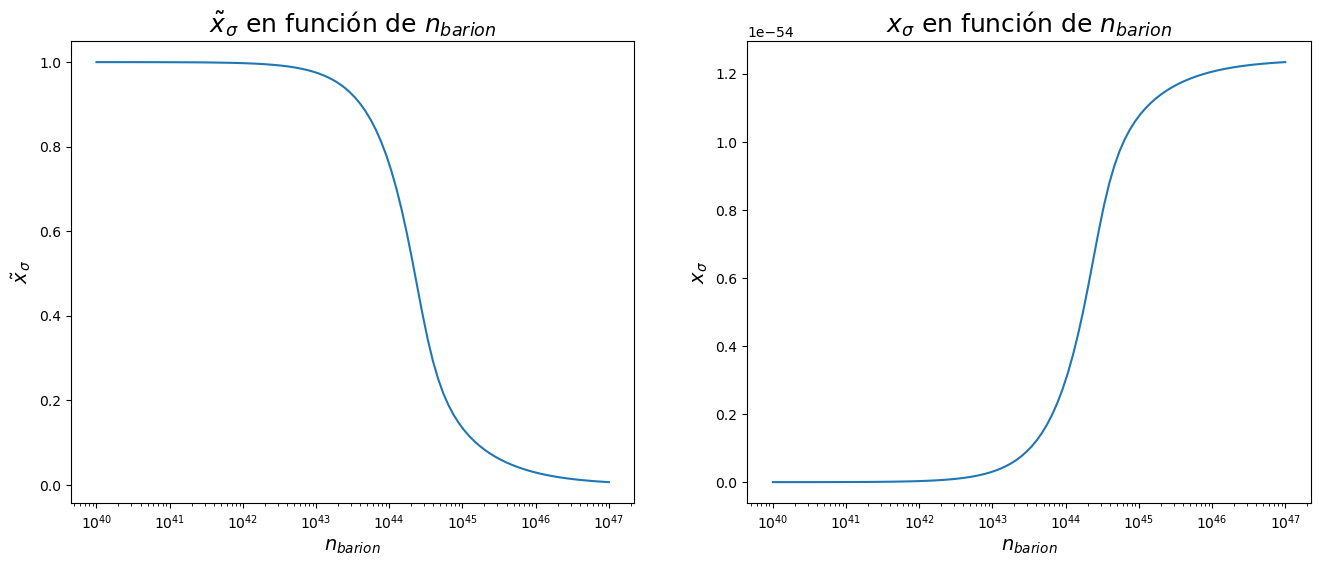

In [98]:
# Testeamos la solucion_x_sigma
n_prove = np.logspace(40, 47, 100)
x_sigma_prove_tilde = np.zeros(len(n_prove))
x_sigma_prove = np.zeros(len(n_prove))
for i in range(len(n_prove)):
    x_sigma_prove_tilde[i] = solucion_x_sigma(n_prove[i], A_sigma)
    x_sigma_prove[i] = (1-x_sigma_prove_tilde[i])*m_nuc

# Mostramos los resultados para x_sigma_tilde y x_sigma en función de n_barion
fig, ax = plt.subplots(1,2, figsize=(16,6))
ax[0].plot(n_prove, x_sigma_prove_tilde)
ax[0].set_xscale('log')
ax[0].set_xlabel(r'$n_{barion}$')
ax[0].set_ylabel(r'$\tilde x_{\sigma}$')
ax[0].set_title(r'$\tilde x_{\sigma}$ en función de $n_{barion}$')
ax[1].plot(n_prove, x_sigma_prove)
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$n_{barion}$')
ax[1].set_ylabel(r'$x_{\sigma}$')
ax[1].set_title(r'$x_{\sigma}$ en función de $n_{barion}$')
plt.show()


Usamos el resultado de la ecuación de autoconsistencia para calcular la densidad de energía y la presión

In [124]:
# Definimos las funciones de densidad de energía y presión

def energia_presion(n_barion, A_sigma, A_omega, rho_0):
    x_sigma = (1-solucion_x_sigma(n_barion, A_sigma))*m_nuc
    p_f = (3*pi**2*hbar**3*n_barion/2)**(1/3) # Momento de Fermi en función de n_barion
    # Las integrales son analíticas
    integral_energia = (1/8)*(p_f*np.sqrt(m_nuc**2+p_f**2-2*m_nuc*x_sigma+x_sigma**2)*(m_nuc**2+2*p_f**2-2*m_nuc*x_sigma+x_sigma**2)-(m_nuc-x_sigma)**4*np.arctanh(p_f/np.sqrt(m_nuc**2+p_f**2-2*m_nuc*x_sigma+x_sigma**2)))
    integral_presion = (1/8)*(p_f*(-3*m_nuc**2+2*p_f**2+6*m_nuc*x_sigma-3*x_sigma**2)*np.sqrt(m_nuc**2+p_f**2-2*m_nuc*x_sigma+x_sigma**2)+3*(m_nuc-x_sigma)**4*np.arctanh(p_f/np.sqrt(m_nuc**2+p_f**2-2*m_nuc*x_sigma+x_sigma**2)))
    energia = (x_sigma**2/(2*A_sigma**2*hbar**2) + 1/2*A_omega**2*hbar**2*n_barion**2 + 2/(pi**2*hbar**3)*integral_energia)/rho_0
    presion = (-x_sigma**2/(2*A_sigma**2*hbar**2) + 1/2*A_omega**2*hbar**2*n_barion**2 + 2/(3*pi**2*hbar**3)*integral_presion)/rho_0
    return energia, presion

def EoS(n_barion, A_sigma, A_omega, rho_0, units = 'GEO'):
    energias = np.array([])
    presiones = np.array([])
    for n in n_barion:
        energia, presion = energia_presion(n, A_sigma, A_omega, rho_0)
        if energia < 0 or energia > 1e10 or presion < 0 or presion > 1e10:
            continue
            # _=1
        energias = np.append(energias, energia)
        presiones = np.append(presiones, presion)
    return CubicSpline(presiones, energias, extrapolate=True), presiones, energias

# Ejemplo
n_barion_max = 1e17*1e3/m_nuc_MKS # 1e17 g/cm^3 de bariones en unidades de m^-3
energia, presion = energia_presion(n_barion_max, A_sigma, A_omega, 1)
print("Energía = ", energia, "y presión = ", presion, "para n_barion = ", n_barion_max)

Energía =  4.153819444933933e-06 y presión =  4.078348977560652e-06 para n_barion =  5.978637491234571e+46


Empleamos las funciones anteriores para interpolar una ecuación de estado $\rho(P)$

In [153]:
# Calculamos la densidad de energía central para una densidad barionica de 1e47
densidad_masa_max = 1e17*1e3 # g/cm^3 a kg/m^3
densidad_masa_min = 1e11*1e3 # g/cm^3 a kg/m^3
# densidad_masa_min = 0
n_barion_max = densidad_masa_max/m_nuc_MKS # m^-3
n_barion_min = densidad_masa_min/m_nuc_MKS # m^-3

rho_0, _ = energia_presion(n_barion_max, A_sigma, A_omega, 1)
print("Densidad central = ", rho_0, "para n_barion_max = ", n_barion_max)

# Definimos el rango de densidades barionicas e interpolamos la ecuación de estado
n_barion = np.linspace(n_barion_min, n_barion_max, 150)
# n_barion = np.logspace(0, np.log10(n_barion_max), 100)
rho_P, presiones, energias = EoS(n_barion, A_sigma, A_omega, rho_0)

Densidad central =  4.153819444933933e-06 para n_barion_max =  5.978637491234571e+46


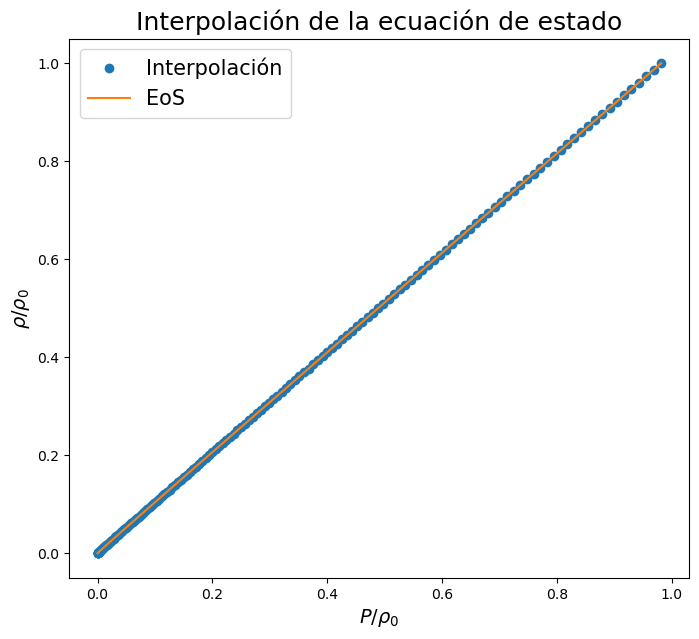

In [154]:
# Graficamos la ecuación de estado rho(P)
plt.figure(figsize=(8, 7))

#Adimensional
plt.plot(presiones, rho_P(presiones), "o", label='Interpolación')
plt.plot(presiones, energias, label='EoS')
plt.xlabel(r'$P/\rho_0$')
plt.ylabel(r'$\rho/\rho_0$')
#MKS
# rho_geoToMKS = c_MKS**4/G_MKS# factor de conversión de densidad de energía y presión de unidades geométricas a MKS
# rho_MKSTocgs = 1e1 # factor de conversión de densidad de energía y presión de unidades MKS a cgs
# plt.loglog(presiones*rho_0*rho_geoToMKS*rho_MKSTocgs, rho_P(presiones)*rho_0*rho_geoToMKS, "o", label='Interpolación')
# plt.loglog(presiones*rho_0*rho_geoToMKS*rho_MKSTocgs, energias*rho_0*rho_geoToMKS, label='EoS')
# plt.xlabel(r'$P$ [Ba]')
# plt.ylabel(r'$\rho$ [erg/cm$^3$]')

plt.title('Interpolación de la ecuación de estado', fontsize=18)
plt.legend()
plt.show()

In [ ]:
# Histograma de energias
plt.figure(figsize=(8, 7))
plt.hist(energias, bins=50)
plt.xlabel(r'$\rho/\rho_0$')
plt.ylabel('Frecuencia')
plt.title('Histograma de energías')
plt.show()

## Solución de las ecuaciones hidrostáticas

### Definición de los sistemas, funciones e integrador

In [160]:
# Definimos una función para convertir las cantidades adimensionales a cantidades físicas
# la adimensionalización es identica en Newton y en GR
def adimensional_to_fisico(sol_fin, P_central, r_fin, rho0):
    P, m, phi, rho = sol_fin
    
    # Obtenemos las constantes de adimensionalización
    P0 = rho0
    R = np.sqrt(c_MKS**4/(4*pi*G_MKS*rho0))
    M = 4*pi*R**3*rho0/c_MKS**2

    # Convertimos las cantidades adimensionales a cantidades físicas
    P_fisico = P0*P_central
    m_fisico = M*m
    phi_fisico = phi
    rho_fisico = rho0
    r_fisico = R*r_fin

    # P y rho finales
    # P_final = P0*P
    # rho_final = rho0*rho

    return [r_fisico, m_fisico, rho_fisico, P_fisico, phi_fisico]

# Definimos el sistema de ecuaciones newtonianas
def newtonianas(sol, r, rho_P):
    # Tomamos las variables
    P, m, phi = sol # Presion, masa y potencial adimensionales

    # Usamos la ecuación de estado para la densidad de energía
    rho = rho_P(P) # Densidad de energia adimensional

    # Definimos las derivadas
    dm_dr = r**2 * rho
    dP_dr = -m*rho/r**2
    dphi_dr = m/r**2

    # Devolvemos las derivadas
    return [dP_dr, dm_dr, dphi_dr]

# Definimos el sistema de ecuaciones GR
def relativistas(sol, r, rho_P):
    # Tomamos las variables
    P, m, phi = sol # Presion, masa y potencial adimensionales

    # Usamos la ecuación de estado para la densidad de energía
    rho = rho_P(P) # Densidad de energia adimensional

    # Definimos las derivadas
    dm_dr = r**2 * rho
    dP_dr = -m*rho/r**2*(1+P/rho)*(1+r**3*P/m)/(1-2*m/r)
    dphi_dr = -dP_dr/(rho + P)

    # Devolvemos las derivadas
    return [dP_dr, dm_dr, dphi_dr]

# Definimos la función que integre y recupere las cantidades fisicas para un valor de rho0 y un sistema de ecuaciones dado
def integrador(rf, dr, rho0_masa, sistema, sol_completa = False):
    # Malla de integración para ambos sistemas
    N = int(rf/dr) # Número de puntos
    r = np.linspace(dr, rf, N) # Puntos de integración

    # Interpolamos la ecuación de estado para obtener rho(P)
    # Calculamos la densidad de energía central para una densidad barionica de 1e47
    densidad_masa_max = 1e17*1e3 # g/cm^3 a kg/m^3
    # densidad_masa_min = 1e11*1e3 # g/cm^3 a kg/m^3
    densidad_masa_min = 0
    n_barion_max = densidad_masa_max/m_nuc_MKS # m^-3
    n_barion_min = densidad_masa_min/m_nuc_MKS # m^-3
    n_barion = np.linspace(n_barion_min, n_barion_max, 250)
    rho_0, _ = energia_presion(rho0_masa*1e3/m_nuc_MKS, A_sigma, A_omega, 1) # Densidad central de energía en unidades geométricas
    # print("Densidad central de energía: ", rho_0, "para rho0_masa = ", rho0_masa)
    rho0 = rho_0*c_MKS**4/G_MKS # Densidad central de energía en MKS
    rho_P, presiones, energias = EoS(n_barion, A_sigma, A_omega, rho_0)
    P_central = CubicSpline(energias, presiones)(1) # Presion central adimensional

    # Definimos las condiciones iniciales en r = dr (para evitar la singularidad en r = 0)
    # estas son cantidades adimensionales, así que rho(0) = 1 y m(0) = 0
    rhoc = 1.0
    m0 = rhoc*dr**3/3 # m = 0 + 0r + 0r^2/2 + 2rho(0)r^3/6 ...
    
    if sistema == 'newtoniano':
        ecuaciones = newtonianas
        P0 = P_central- rhoc * dr**2 / 6.0
        phi0 = 1 + rhoc**2*dr**2/6
    elif sistema == 'relativista':
        ecuaciones = relativistas
        P0 = P_central- ( 3.0*P_central**2 + 4.0*P_central*rhoc + rhoc**2)*dr**2/6.0
        phi0 = 1 + ( rhoc/3.0 + P_central ) * dr**2 / 2.0

    # Resolvemos el sistema de ecuaciones
    sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T

    # Obtenemos la densidad a partir de las presiones
    P, m, phi = sol
    rho = rho_P(P)

    # Buscamos el radio donde la densidad es cero
    lim = len(r)-1
    # la condicion debe ser con P, no siempre cuando P=0, rho=0
    for i in range(len(P)):
        if P[i] <= 0:
            lim = i-1
            break
    # print("Radio de la estrella: ", r[lim], " en el paso ", lim, " de ", N)

    # Obtenemos las cantidades finales
    sol_fin = [P[lim], m[lim], phi[lim], rho[lim]]

    if sol_completa:
        return adimensional_to_fisico(sol_fin, P_central, r[lim], rho0), np.append(sol[:, :lim], [rho[:lim]], axis=0), r[:lim]
    else:
        # Convertimos las cantidades adimensionales a cantidades físicas
        return adimensional_to_fisico(sol_fin, P_central, r[lim], rho0)

# Malla de integración para ambos sistemas
rf = 50 # Radio adimensional final
dr = 1e-3 # Paso de integración
N = int(rf/dr) # Número de puntos
r = np.linspace(dr, rf, N) # Puntos de integración

### Relación Masa Radio y Masa Densidad Central

In [161]:
# Definimos el rango de densidades de masa para el cual queremos integrar
rhos = np.linspace(14, 18, 50)
rhos = np.power(10, rhos)

# Integramos para cada densidad de masa
masas_N  = np.array([])
radios_N = np.array([])
masas_R  = np.array([])
radios_R = np.array([])

for rho in rhos:
    sol_N    = integrador(rf, dr, rho, 'newtoniano')
    sol_R    = integrador(rf, dr, rho, 'relativista')
    masas_N  = np.append(masas_N, sol_N[1])
    radios_N = np.append(radios_N, sol_N[0])
    masas_R  = np.append(masas_R, sol_R[1])
    radios_R = np.append(radios_R, sol_R[0])

C:\Users\nicom\AppData\Local\Temp\ipykernel_4176\161631047.py:91: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T


20.397771403286765


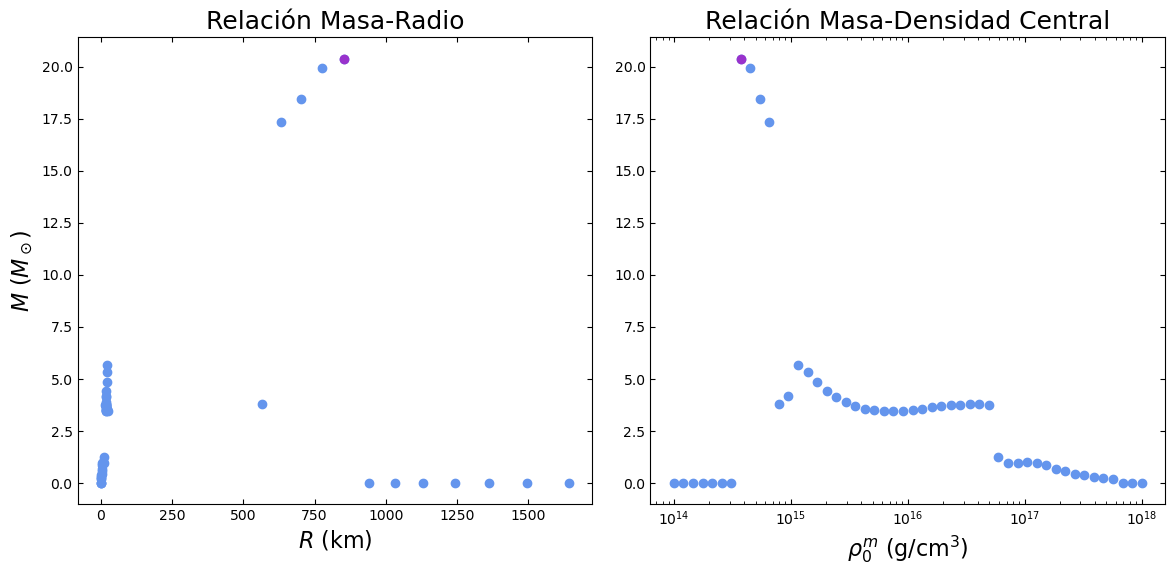

In [162]:
# Graficamos las relaciones masa radio y masa densidad en masas solares
masasolar=1.989e30
color = "cornflowerblue"
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].loglog(radios_N/1e3, masas_N/masasolar, label='Newtoniano')
# ax[0].loglog(radios_R/1e3, masas_R/masasolar, label='Relatividad General')
# ax[0].legend()
ax[0].plot(radios_R/1e3, masas_R/masasolar, 'o', color=color, linewidth=2)
ax[0].set_xlabel(r'$R$ (km)', fontsize=16)
ax[0].set_ylabel(r'$M$ ($M_\odot$)', fontsize=16)
ax[0].set_title(r'Relación Masa-Radio', fontsize=18)
ax[0].tick_params(axis='both', which='both', direction='in', right=True, top=True)
#Punto en la masa maxima
ax[0].plot(radios_R[np.argmax(masas_R)]/1e3, masas_R.max()/masasolar, 'o', color='darkorchid')

# ax[1].loglog(rhos, masas_N/masasolar, label='Newtoniano')
# ax[1].loglog(rhos, masas_R/masasolar, label='Relatividad General')
# ax[1].legend()
ax[1].semilogx(rhos, masas_R/masasolar, 'o', color=color, linewidth=2)
ax[1].set_xlabel(r'$\rho_0^m$ (g/cm$^3$)', fontsize=16)
# ax[1].set_ylabel(r'$M$ ($M_\odot$)')
ax[1].set_title(r'Relación Masa-Densidad Central', fontsize=18)
ax[1].tick_params(axis='both', which='both', direction='in', right=True, top=True)
#Punto en la masa maxima
ax[1].plot(rhos[np.argmax(masas_R)], masas_R.max()/masasolar, 'o', color='darkorchid')

print(masas_R.max()/masasolar)

plt.tight_layout()
plt.show()

### Sistema GR con la masa máxima

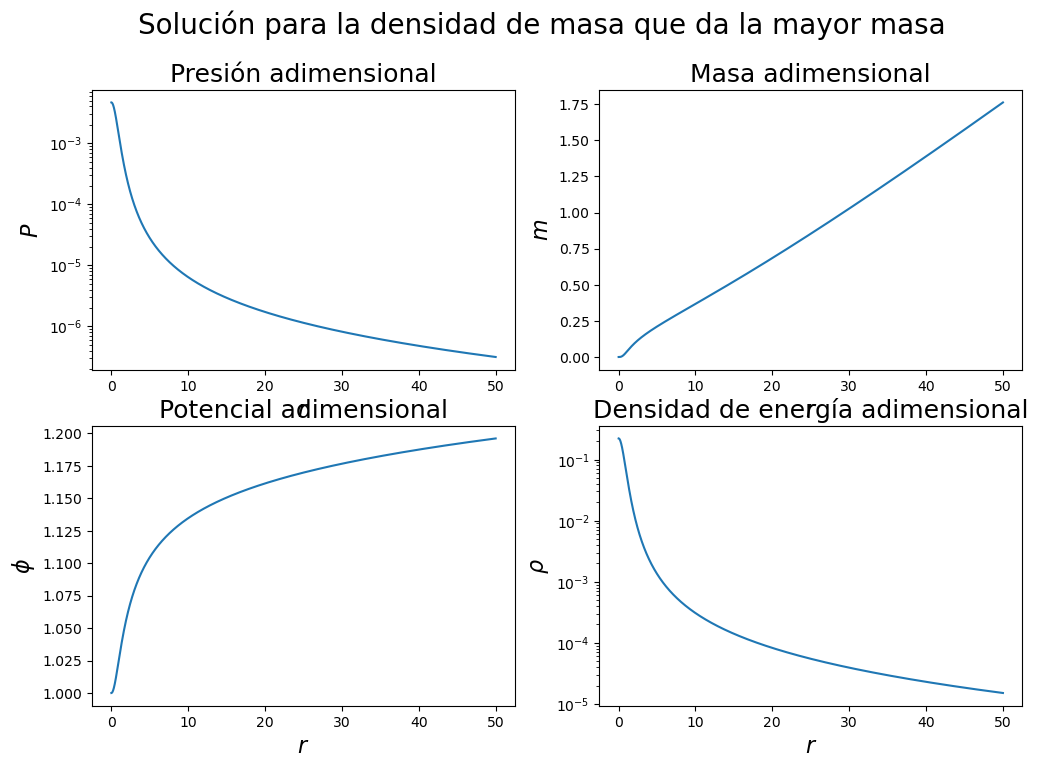

In [127]:
# Integramos para la densidad de masa que da la mayor masa
sol_final, sol_masa_max_R, r = integrador(rf, dr, rhos[np.argmax(masas_R)], 'relativista', sol_completa=True)

# Obtenemos la densidad a partir de las presiones
P_R, m_R, phi_R, rho_R = sol_masa_max_R

# Graficamos las soluciones
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0, 0].semilogy(r, P_R, label=r'$P$')
ax[0, 0].set_xlabel(r'$r$', fontsize=16)
ax[0, 0].set_ylabel(r'$P$', fontsize=16)
ax[0, 0].set_title(r'Presión adimensional', fontsize=18)

ax[0, 1].plot(r, m_R, label=r'$m$')
ax[0, 1].set_xlabel(r'$r$', fontsize=16)
ax[0, 1].set_ylabel(r'$m$', fontsize=16)
ax[0, 1].set_title(r'Masa adimensional', fontsize=18)

ax[1, 0].plot(r, phi_R, label=r'$\phi$')
ax[1, 0].set_xlabel(r'$r$', fontsize=16)
ax[1, 0].set_ylabel(r'$\phi$', fontsize=16)
ax[1, 0].set_title(r'Potencial adimensional', fontsize=18)

ax[1, 1].semilogy(r, rho_R, label=r'$\rho$')
ax[1, 1].set_xlabel(r'$r$', fontsize=16)
ax[1, 1].set_ylabel(r'$\rho$', fontsize=16)
ax[1, 1].set_title(r'Densidad de energía adimensional', fontsize=18)

# plt.tight_layout()
plt.suptitle('Solución para la densidad de masa que da la mayor masa', fontsize=20)
plt.show()